In [1]:
import lsst.daf.persistence
import lsst.afw.table as afwTable

%matplotlib inline
import matplotlib.pyplot as pyplot
from math import *

import numpy as np
import pandas as pd
import dask.dataframe as dd
import numba

import astropy.io.fits as io_fits

First get the data with by opening a fits file directly with astropy

In [2]:
hdu = io_fits.open('ref-0-17,13.fits')
header = hdu[1].header
table  = hdu[1].data

flags = table['flags']
ids   = table['id']

In [42]:
header;

In [3]:
flags[1000].astype(int)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0])

In [4]:
TFLAG_PRIMARY = 129

for i in range(1000,1010):
    
    sub_array = [flags[i][j*64:(j+1)*64] for j in range(3)]

    #print(sub_array[0], sub_array[1], sub_array[2])
    #print([[2**i for i,flag in enumerate(value) if flag] for value in sub_array])

    FLAGS = [sum([2**i for i,flag in enumerate(value) if flag]) for value in sub_array]
    print(i, ids[i], flags[i][TFLAG_PRIMARY-1], FLAGS[0], FLAGS[1], FLAGS[2])

1000 149547540022249 False 2533274790461956 13997487808541884416 512
1001 149547540022250 True 516 14015502207051366400 513
1002 149547540022251 False 2533274790461956 14008597688560386048 640
1003 149547540022252 False 2533274790461956 14573948560845307904 512
1004 149547540022253 True 516 13997487808541884416 513
1005 149547540022254 True 516 14591962959354789888 513
1006 149547540022255 True 516 14591962959354789888 513
1007 149547540022256 False 2533274790461956 13997487808541884416 512
1008 149547540022257 True 4785074604081668 14591962959354789888 513
1009 149547540022258 False 2533274790461956 13997488220858744832 512


Let's also read this directly from the file with afwTable and see that we can get the same thing.

In [43]:
afw_table = afwTable.SourceCatalog.readFits('ref-0-17,13.fits')

afw_schema = afw_table.getSchema()
for i in afw_schema:
    if i.key.dtype == "Flag":
        flag_name = i.field.getName()
        # print("Name:", flag_name)
        if flag_name == 'detect_isPrimary':
            print("I found it!")
            
detect_isPrimary = afw_table.get("detect_isPrimary")
print(detect_isPrimary[1000:1010])

I found it!
[False  True False False  True  True  True False  True False]


Now let's do it with the Butler

In [6]:
DATA_DIR_DITHERED = "/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered/"
butler = lsst.daf.persistence.Butler(DATA_DIR_DITHERED)

In [7]:
calexpId = {'visit':1919421, 'filter':'r', 'raft':'2,2', 'sensor':'1,1'}
coaddId = {'patch':'17,13', 'tract':0, 'filter':'r'}

calexp = butler.get('calexp', dataId=calexpId)
calexp_src = butler.get('src', dataId=calexpId)
coadd = butler.get('deepCoadd', dataId=coaddId)
coadd_src = butler.get('deepCoadd_meas', dataId=coaddId)

coadd_src.getSchema();

In [8]:
coadd_src.get("detect_isPrimary")[1000:1100];

In [9]:
for i in range(1000,1010):
    id = coadd_src[i].get('id')
    is_primary = coadd_src[i].get("detect_isPrimary")
    print(i, id, is_primary)

1000 149547540022249 False
1001 149547540022250 True
1002 149547540022251 False
1003 149547540022252 False
1004 149547540022253 True
1005 149547540022254 True
1006 149547540022255 True
1007 149547540022256 False
1008 149547540022257 True
1009 149547540022258 False


Now finally the pandas frames I extracted from the SQL DB.  The flags don't exist as booleans there,  I have three uint64 intetegers I need to reconstruct them from.

In [10]:
%%time

file_path = "/global/project/projectdirs/lsst/cwalter/DC1-HDF5/"
df = dd.read_hdf(file_path+'Coadd_dithered.hdf', key='/*')

requested_columns = ['id','FLAGS1','FLAGS2','FLAGS3','coord_ra','coord_dec','patch']

selected = df[requested_columns].compute()
selected_patch = df.query("patch == \"'17,13'\"")[requested_columns].compute()

CPU times: user 2min 42s, sys: 1min 53s, total: 4min 36s
Wall time: 4min 37s


In [11]:
selected_patch[1000:1010]

,id,FLAGS1,FLAGS2,FLAGS3,coord_ra,coord_dec,patch
556572,149547540022249,2533274790461956,13997487808541884416,512,1.625269,-0.510834,"'17,13'"
556573,149547540022250,516,14015502207051366400,513,1.622141,-0.510786,"'17,13'"
556574,149547540022251,2533274790461956,14008597688560386048,640,1.630350,-0.510895,"'17,13'"
556575,149547540022252,2533274790461956,14573948560845307904,512,1.627224,-0.510866,"'17,13'"
556576,149547540022253,516,13997487808541884416,513,1.625739,-0.510837,"'17,13'"
556577,149547540022254,516,14591962959354789888,513,1.623313,-0.510802,"'17,13'"
556578,149547540022255,516,14591962959354789888,513,1.622860,-0.510796,"'17,13'"
556579,149547540022256,2533274790461956,13997487808541884416,512,1.622507,-0.510787,"'17,13'"
556580,149547540022257,4785074604081668,14591962959354789888,513,1.622190,-0.510782,"'17,13'"
556581,149547540022258,2533274790461956,13997488220858744832,512,1.621368,-0.510766,"'17,13'"


This code will reverse the bits of each word, account for the fact that the last word has only 14 bits and reconstruct the boolean array.

In [12]:
TFLAG_PRIMARY = 129

def analysis_flags(FLAGS1, FLAGS2, FLAGS3, bit):
    """
    A function to repaste the three FLAG integers backtogether and
    recover the analysis flag bit mask.
    """
    string = '{:064b}'.format(FLAGS1)[::-1] + '{:064b}'.format(FLAGS2)[::-1] \
           + '{:014b}'.format(FLAGS3)[::-1]
        
    bit_mask = np.array(list(string), dtype=np.int).astype(np.bool)
    
    return bit_mask[bit]

Check that if I use this I can get the same flags as above.

In [13]:
for i in range(1000,1010):
    
    id = selected_patch.iloc[i].id
    FLAGS1 = selected_patch.iloc[i].FLAGS1
    FLAGS2 = selected_patch.iloc[i].FLAGS2
    FLAGS3 = selected_patch.iloc[i].FLAGS3

    is_primary = analysis_flags(FLAGS1, FLAGS2, FLAGS3, TFLAG_PRIMARY-1)
    print(i, id, is_primary)

1000 149547540022249 False
1001 149547540022250 True
1002 149547540022251 False
1003 149547540022252 False
1004 149547540022253 True
1005 149547540022254 True
1006 149547540022255 True
1007 149547540022256 False
1008 149547540022257 True
1009 149547540022258 False


Now add a new column to the dataframe byt applying this function.  This is slow since there are 12 million objects to go through.

In [14]:
%%script false

selected['detect_isPrimary'] = selected.apply(
    lambda x: analysis_flags(x.FLAGS1, x.FLAGS2, x.FLAGS3, TFLAG_PRIMARY-1), axis=1)

By pulling the data out first into numpy arrays and looping  through them myself I can speed this up by a factor of 2.

In [15]:
%%time

def frame_loop(FLAGS1, FLAGS2, FLAGS3, bit):

    is_primary = np.empty(FLAGS1.size, dtype=np.bool)

    for i in range(FLAGS1.size):
        is_primary[i] = analysis_flags(FLAGS1[i], FLAGS2[i], FLAGS3[i], bit)
        
    return is_primary

selected['detect_isPrimary'] = frame_loop(
    selected.FLAGS1.values, selected.FLAGS2.values, selected.FLAGS3.values, TFLAG_PRIMARY-1)

CPU times: user 5min 27s, sys: 27.8 s, total: 5min 55s
Wall time: 5min 37s


In [16]:
selected.query("patch == \"'17,13'\"")[1000:1010]

,id,FLAGS1,FLAGS2,FLAGS3,coord_ra,coord_dec,patch,detect_isPrimary
556572,149547540022249,2533274790461956,13997487808541884416,512,1.625269,-0.510834,"'17,13'",False
556573,149547540022250,516,14015502207051366400,513,1.622141,-0.510786,"'17,13'",True
556574,149547540022251,2533274790461956,14008597688560386048,640,1.630350,-0.510895,"'17,13'",False
556575,149547540022252,2533274790461956,14573948560845307904,512,1.627224,-0.510866,"'17,13'",False
556576,149547540022253,516,13997487808541884416,513,1.625739,-0.510837,"'17,13'",True
556577,149547540022254,516,14591962959354789888,513,1.623313,-0.510802,"'17,13'",True
556578,149547540022255,516,14591962959354789888,513,1.622860,-0.510796,"'17,13'",True
556579,149547540022256,2533274790461956,13997487808541884416,512,1.622507,-0.510787,"'17,13'",False
556580,149547540022257,4785074604081668,14591962959354789888,513,1.622190,-0.510782,"'17,13'",True
556581,149547540022258,2533274790461956,13997488220858744832,512,1.621368,-0.510766,"'17,13'",False


Now, let's use this to select only the primary objects.

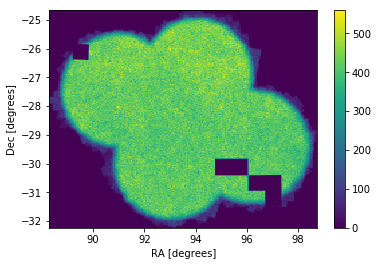

In [17]:
primary = selected.query("detect_isPrimary==True")
#primary = selected
ra = primary['coord_ra']*180/pi
dec = primary['coord_dec']*180/pi

#plt.scatter(ra, dec, marker='.',color='k')
pyplot.hist2d(ra, dec, bins=200)
pyplot.xlabel('RA [degrees]')
pyplot.ylabel('Dec [degrees]')
pyplot.colorbar()

In [36]:
grouped = selected.groupby(['detect_isPrimary','patch'])

In [37]:
grouped.count()

id  FLAGS1  FLAGS2  FLAGS3  coord_ra  coord_dec
detect_isPrimary patch                                                      
False            '10,10'  16215   16215   16215   16215     16215      16215
                 '10,11'  19406   19406   19406   19406     19406      19406
                 '10,12'  19425   19425   19425   19425     19425      19425
                 '10,13'  19703   19703   19703   19703     19703      19703
                 '10,14'  19039   19039   19039   19039     19039      19039
                 '10,15'  10507   10507   10507   10507     10507      10507
                 '10,16'    443     443     443     443       443        443
                 '10,8'     215     215     215     215       215        215
                 '10,9'    3615    3615    3615    3615      3615       3615
                 '11,11'  20022   20022   20022   20022     20022      20022
                 '11,12'  20048   20048   20048   20048     20048      20048
                 '11,13'  19703   19703   19703   19703     19703      19703
                 '11,14'  20173   20173   20173   20173     20173      20173
                 '11,15'  19334   19334   19334   19334     19334      19334
                 '11,16'   3964    3964    3964    3964      3964       3964
                 '11,8'     228     228     228     228       228        228
                 '12,11'  20167   20167   20167   20167     20167      20167
                 '12,12'  19815   19815   19815   19815     19815      19815
                 '12,13'  19625   19625   19625   19625     19625      19625
                 '12,14'  20027   20027   20027   20027     20027      20027
                 '12,15'  19851   19851   19851   19851     19851      19851
                 '12,16'  11220   11220   11220   11220     11220      11220
                 '12,17'   7587    7587    7587    7587      7587       7587
                 '12,18'   4811    4811    4811    4811      4811       4811
                 '12,19'    452     452     452     452       452        452
                 '12,8'     674     674     674     674       674        674
                 '12,9'   14739   14739   14739   14739     14739      14739
                 '13,10'  20564   20564   20564   20564     20564      20564
                 '13,12'  19739   19739   19739   19739     19739      19739
                 '13,13'  19844   19844   19844   19844     19844      19844
...                         ...     ...     ...     ...       ...        ...
True             '22,16'  74360   74360   74360   74360     74360      74360
                 '22,17'  76062   76062   76062   76062     76062      76062
                 '22,18'  74110   74110   74110   74110     74110      74110
                 '22,19'  35080   35080   35080   35080     35080      35080
                 '23,12'    772     772     772     772       772        772
                 '23,13'  30748   30748   30748   30748     30748      30748
                 '23,14'  73765   73765   73765   73765     73765      73765
                 '23,15'  73908   73908   73908   73908     73908      73908
                 '23,16'  73656   73656   73656   73656     73656      73656
                 '23,17'  74281   74281   74281   74281     74281      74281
                 '23,19'   6613    6613    6613    6613      6613       6613
                 '24,13'   1061    1061    1061    1061      1061       1061
                 '24,14'  20414   20414   20414   20414     20414      20414
                 '24,15'  45712   45712   45712   45712     45712      45712
                 '24,16'  44261   44261   44261   44261     44261      44261
                 '24,17'  30294   30294   30294   30294     30294      30294
                 '24,18'   4455    4455    4455    4455      4455       4455
                 '25,14'    323     323     323     323       323        323
                 '25,15'   2867    2867    2867    2867      2867       2867
                 '25,16' 